In [1]:
import Models.Segnet
import Models.Unet
import Models.PspNet
import Models.DeepLab

import sys
import os
import tensorflow as tf
import random
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, f1_score, jaccard_score

modelList = ['Unet','DeepLab','Segnet','PspNet']



In [2]:
gtPath = "_outSeg/" # This set is now a new set produced by the simulator not seen during training
rgbPath = "_out/"

gtFileNames = os.listdir(gtPath)
outFileNames = os.listdir(rgbPath)

matchingFiles = set(outFileNames) & set(gtFileNames)

In [3]:
NumTrainingImages = len(matchingFiles)
StartingIndex = 0

#random.seed(2)
#FileNames = random.sample(matchingFiles, NumTrainingImages)

                            
#gtFileNames = gtFileNames[StartingIndex:StartingIndex+NumTrainingImages]
#outFileNames = outFileNames [StartingIndex:StartingIndex+NumTrainingImages]

for i in range(0,NumTrainingImages):
    gtFileNames[i] = gtPath + gtFileNames[i]
    outFileNames[i] = rgbPath + outFileNames[i]
    

In [4]:
from sklearn.model_selection import train_test_split

#X_train, X_test, y_train, y_test = train_test_split(outFileNames, gtFileNames, test_size=0.2, random_state=1)

#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

X_test = outFileNames
y_test = gtFileNames

In [5]:
def loadImage(outPath, gtPath):
    
    img = tf.io.read_file(outPath)
    img = tf.image.decode_png(img, channels=3)
    img = tf.cast(img, tf.float32) / 255.0
    img = img[:1000, 460:1460, :] # Crop the photo (bonnet &)
    img = tf.image.resize(img, (256, 256), method='nearest')
    
    mask = tf.io.read_file(gtPath)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    mask = mask[:1000, 460:1460, :] # Crop the bonnet
    mask = tf.image.resize(mask, (256, 256), method='nearest')
    
    return img, mask

In [6]:
def genDataset(outPath, gtPath, bufferSize, batchSize):
    
    imageList = tf.constant(outPath) 
    maskList = tf.constant(gtPath)
    dataset = tf.data.Dataset.from_tensor_slices((imageList, maskList))
    dataset = dataset.map(loadImage, num_parallel_calls=tf.data.AUTOTUNE)
    
    dataset = dataset.cache().batch(batchSize)
    
    return dataset



In [7]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = tf.expand_dims(pred_mask, axis=-1)
    return pred_mask[0]


In [8]:
def display(display_list):
    plt.figure(figsize=(18, 18))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

In [9]:
def show_predictions(model, dataset, num):
    predictions = []
    masks = []
    for image, mask in dataset.take(num):
        pred_mask = model.predict(image)
        display([image[0], mask[0], create_mask(pred_mask)])
        predictions.append(create_mask(pred_mask))
        masks.append(mask[0])
    return predictions,masks


In [10]:
def predictDataset(dataset,model):
    preds = []
    masks = []
    for image, mask in dataset.take(len(dataset)):
        pred_mask = model.predict(image,verbose=0)
        masks.append(np.squeeze(mask[0]))
        preds.append(np.squeeze(create_mask(pred_mask)))
    flat_preds = np.concatenate(preds).flatten()
    flat_masks = np.concatenate(masks).flatten()
    return flat_preds,flat_masks


In [11]:
def predictDatasetImages(dataset,model):
    preds = []
    masks = []
    for image, mask in dataset.take(len(dataset)):
        pred_mask = model.predict(image,verbose=0)
        masks.append(np.squeeze(mask[0]))
        preds.append(np.squeeze(create_mask(pred_mask)))
    return preds,masks

In [12]:

def calculate_metrics(true_masks, predicted_masks):
    accuracy = accuracy_score(true_masks.flatten(), predicted_masks.flatten())
    precision = precision_score(true_masks.flatten(), predicted_masks.flatten(), average='weighted', zero_division=0)
    f1 = f1_score(true_masks.flatten(), predicted_masks.flatten(), average='weighted', zero_division=0)
    jaccard = jaccard_score(true_masks.flatten(), predicted_masks.flatten(), average='weighted', zero_division=0)
    return accuracy, precision, f1, jaccard

In [13]:
def convert_to_cityscapes_palette(image_array):
    plt.imsave("temp/temp.png", image_array)
    img =cv2.imread("temp/temp.png")
    return img

In [14]:
import cv2

def predictAllVideos(preds,masks,modelChoice):
    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v') 
    video = cv2.VideoWriter(modelChoice+'_predicted_video_both.mp4', fourcc, 3, (512, 256))  # Change the file name and frame rate if needed
    
    for pred,mask in zip(preds,masks):
        concatenated_img = np.concatenate((mask, pred), axis=1)
        img = np.uint8(concatenated_img)
        color_mapped_img = convert_to_cityscapes_palette(img)
        video.write(color_mapped_img)
    video.release()
    cv2.destroyAllWindows()

    
    fourcc = cv2.VideoWriter_fourcc(*'mp4v') 
    video = cv2.VideoWriter(modelChoice+'_predicted_video.mp4', fourcc, 3, (256, 256))  # Change the file name and frame rate if needed
    
    for pred in preds:
        img = np.uint8(pred)
        color_mapped_img = convert_to_cityscapes_palette(img)
        video.write(color_mapped_img)
    video.release()
    cv2.destroyAllWindows()

    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v') 
    video = cv2.VideoWriter(modelChoice+'_mask_video.mp4', fourcc, 3, (256, 256))  # Change the file name and frame rate if needed
    
    for image in masks:
        img = np.uint8(image)
        color_mapped_img = convert_to_cityscapes_palette(img)
        video.write(color_mapped_img)
    video.release()
    cv2.destroyAllWindows()




-------------------------------------------------------
------------------- Testing: Unet -----------------------
-------------------------------------------------------
Training time: 56.72722792625427 seconds
Accuracy: 0.9612879349013507
Precision: 0.9604734521727987
F1 Score: 0.9602911997920474
Jaccard Index (IoU): 0.9317782064460316
[[877321      0]
 [     0      0]]
1/1 [==============================] - 0s 25ms/step


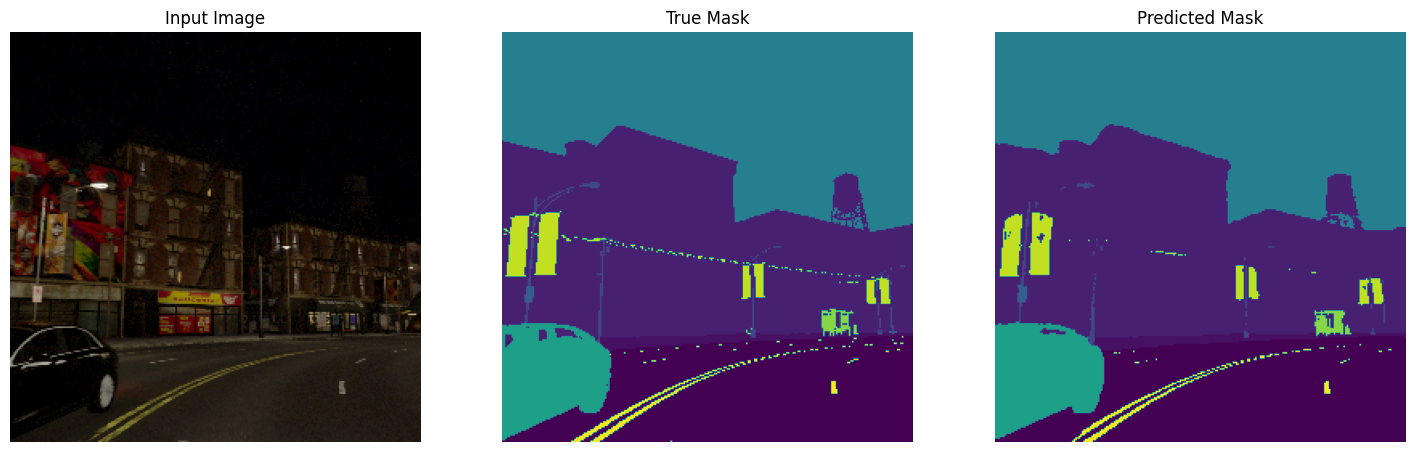

1/1 [==============================] - 0s 25ms/step


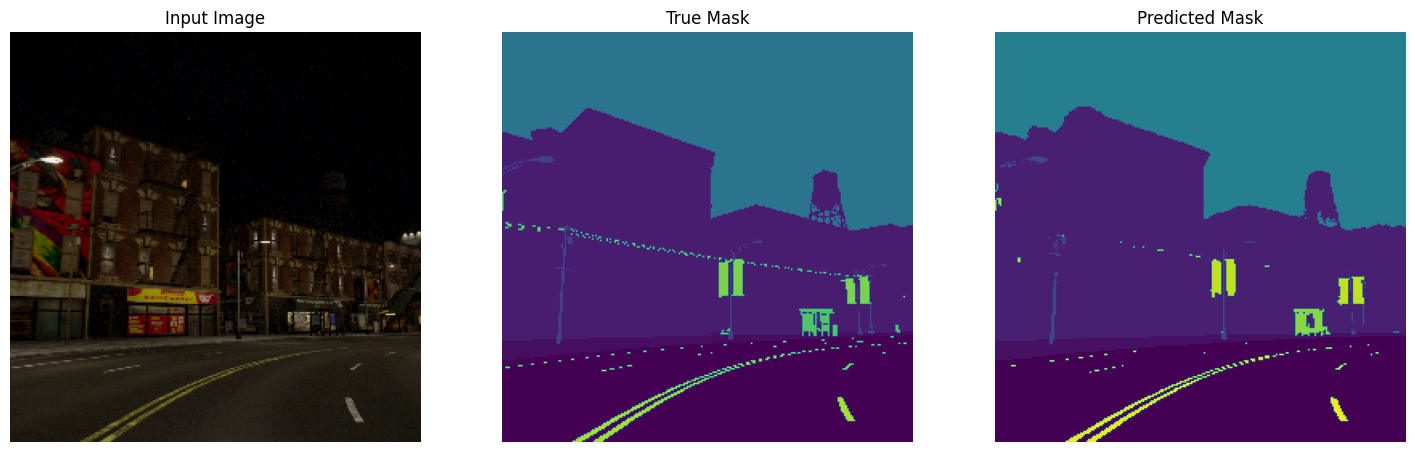

1/1 [==============================] - 0s 24ms/step


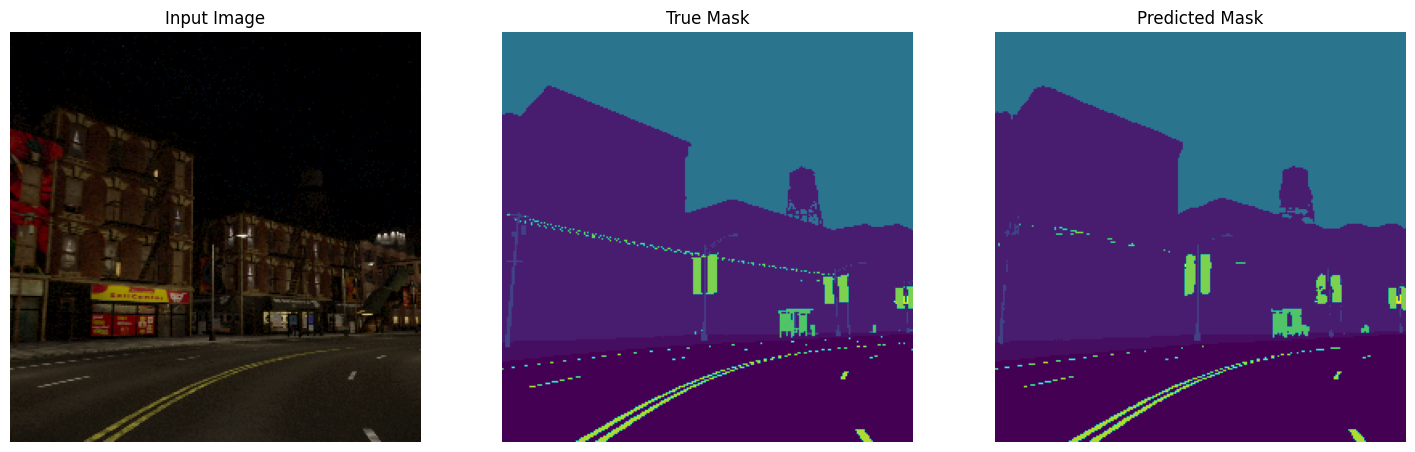

1/1 [==============================] - 0s 22ms/step


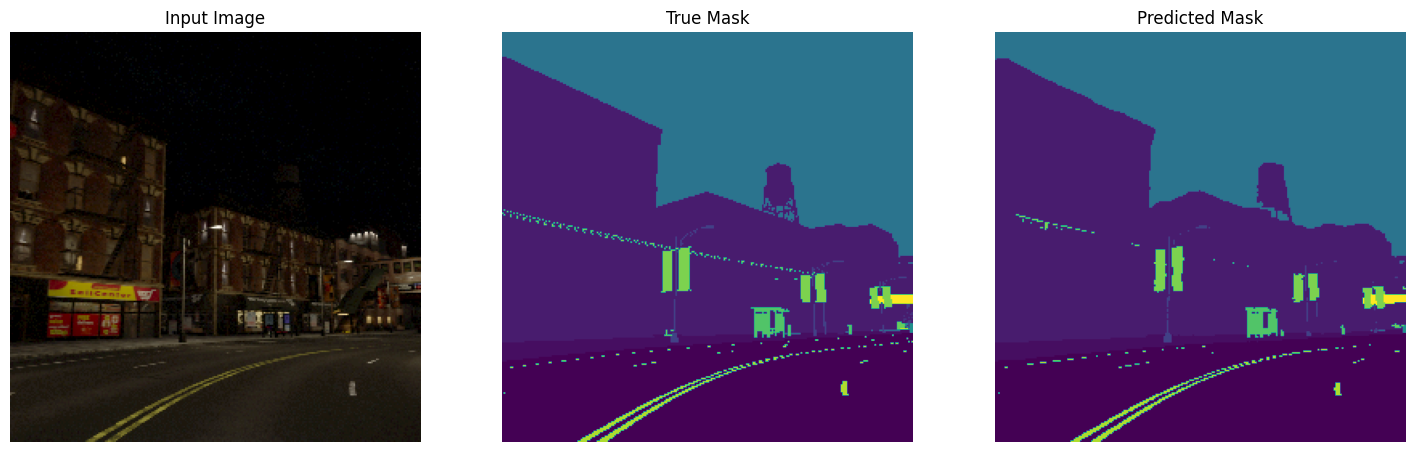

-------------------------------------------------------
------------------- Testing: DeepLab -----------------------
-------------------------------------------------------
Training time: 43.150084495544434 seconds
Accuracy: 0.9249872757216632
Precision: 0.9150419506849592
F1 Score: 0.9164987601159834
Jaccard Index (IoU): 0.8690789489158517
[[865864      0]
 [     0      0]]
1/1 [==============================] - 0s 26ms/step


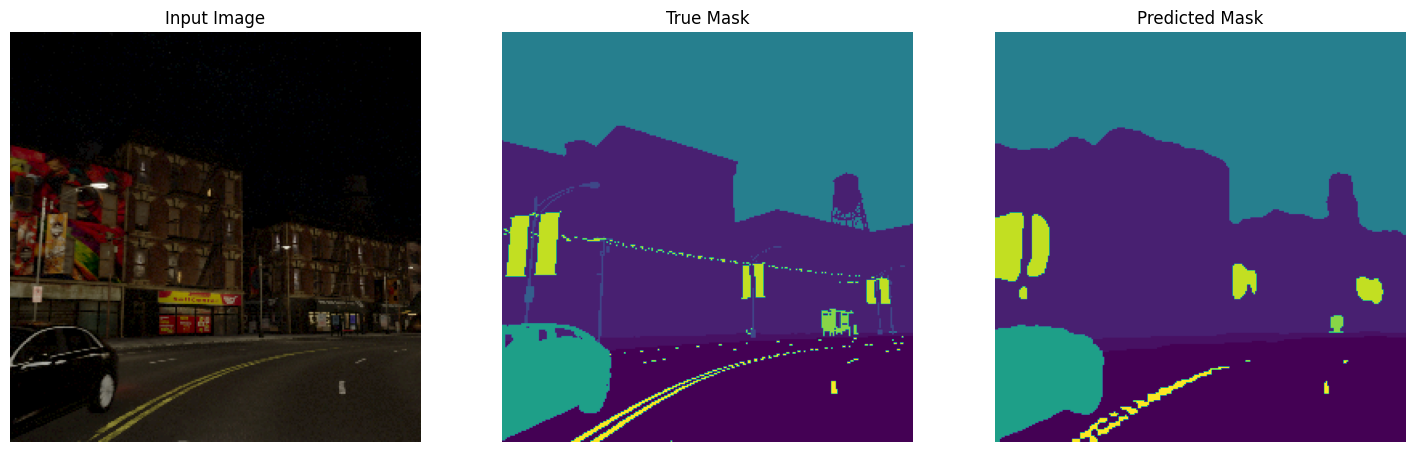

1/1 [==============================] - 0s 24ms/step


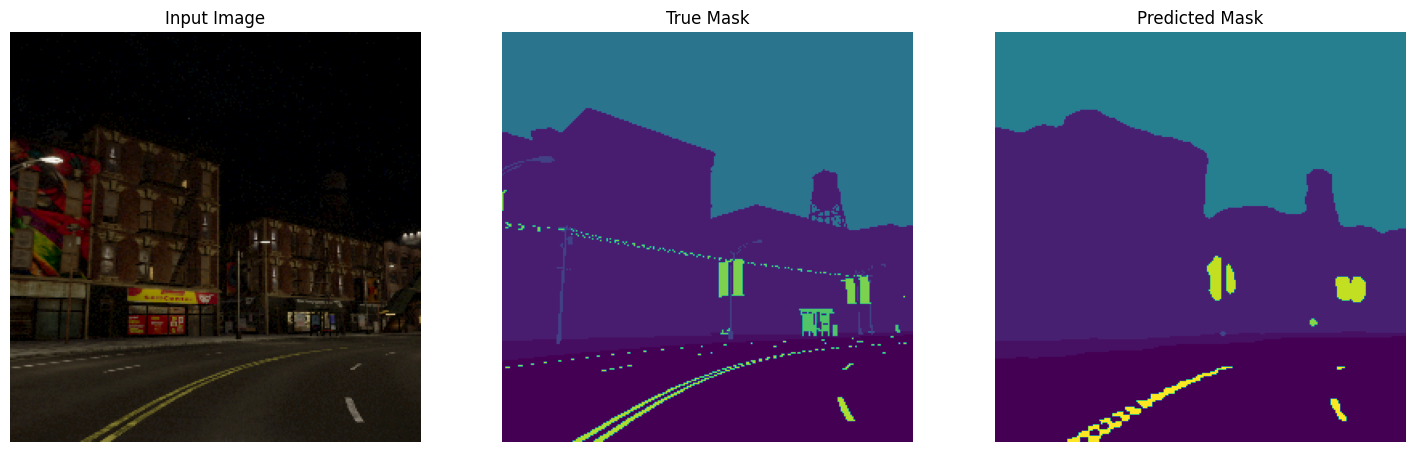

1/1 [==============================] - 0s 23ms/step


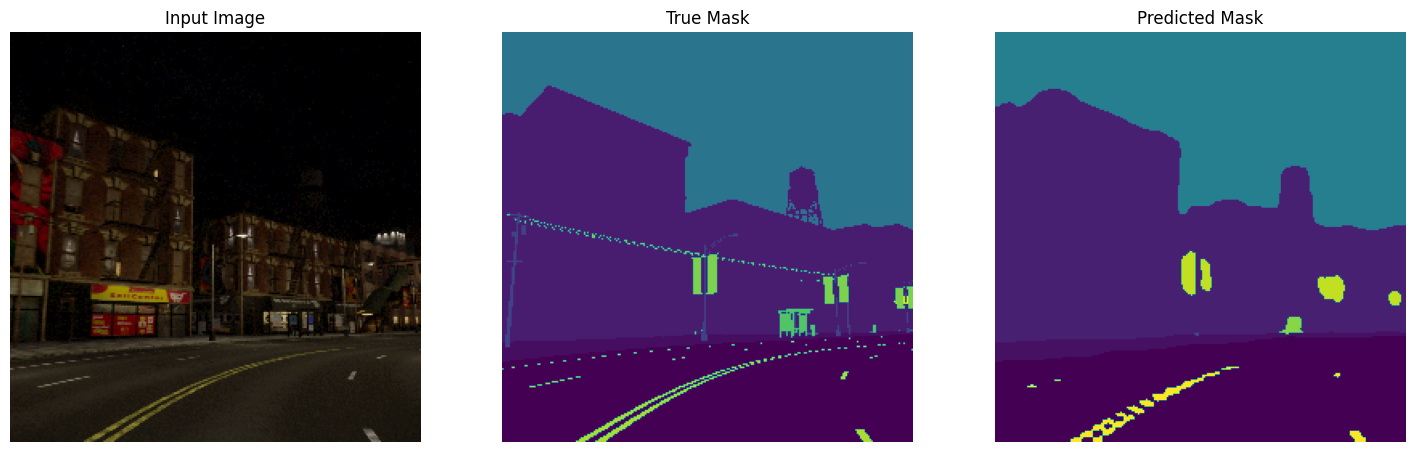

1/1 [==============================] - 0s 24ms/step


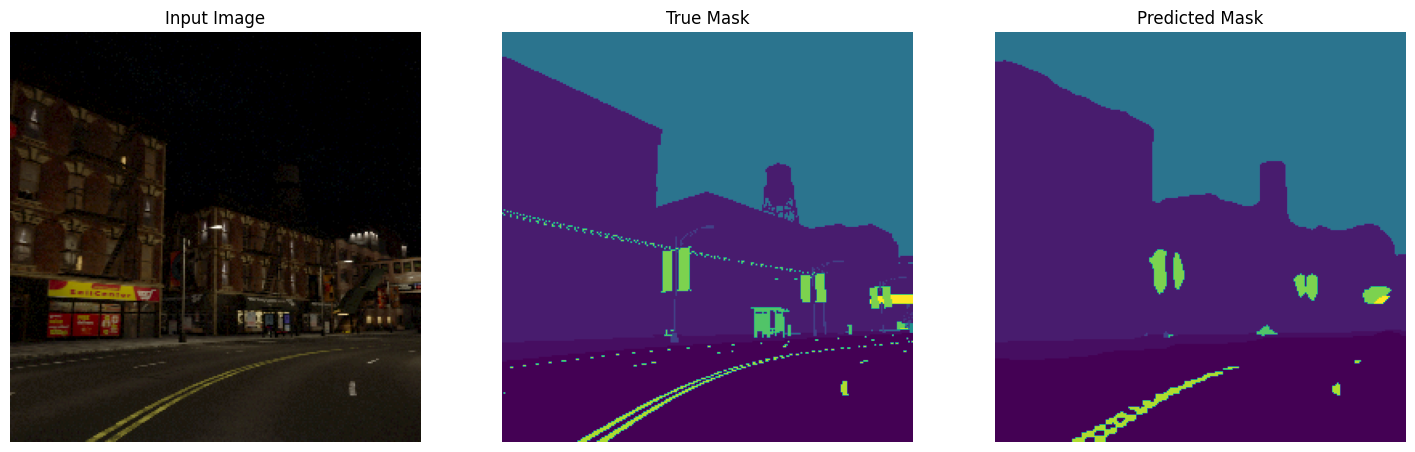

-------------------------------------------------------
------------------- Testing: Segnet -----------------------
-------------------------------------------------------
Training time: 60.170923471450806 seconds
Accuracy: 0.8164846654881768
Precision: 0.8205715498034469
F1 Score: 0.7818152370198428
Jaccard Index (IoU): 0.7034710135374802
[[2759615       0]
 [      0       0]]
1/1 [==============================] - 0s 454ms/step


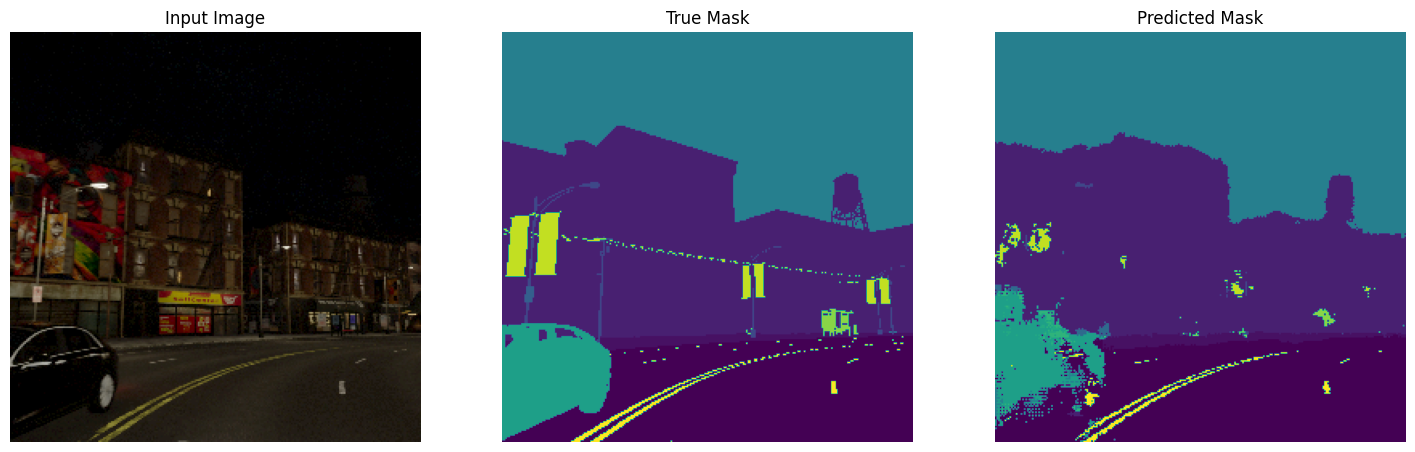

1/1 [==============================] - 0s 115ms/step


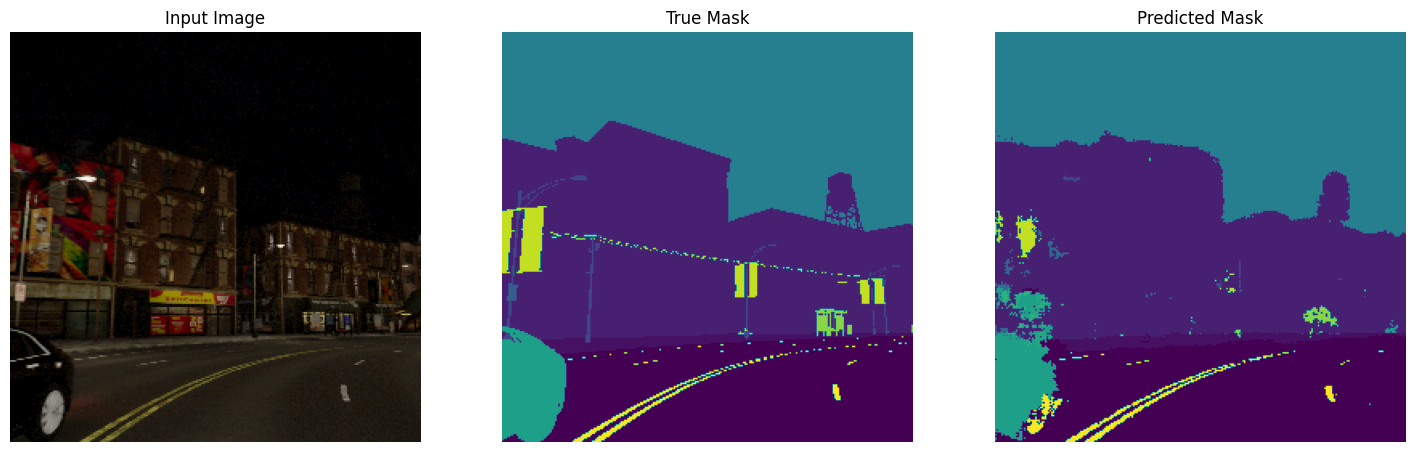

1/1 [==============================] - 0s 114ms/step


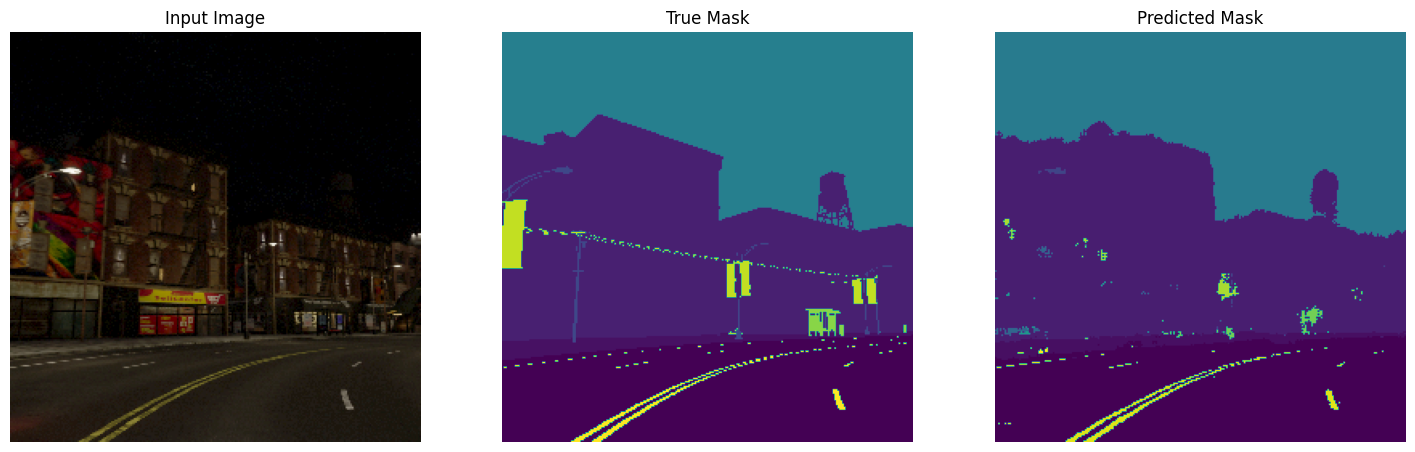

1/1 [==============================] - 0s 120ms/step


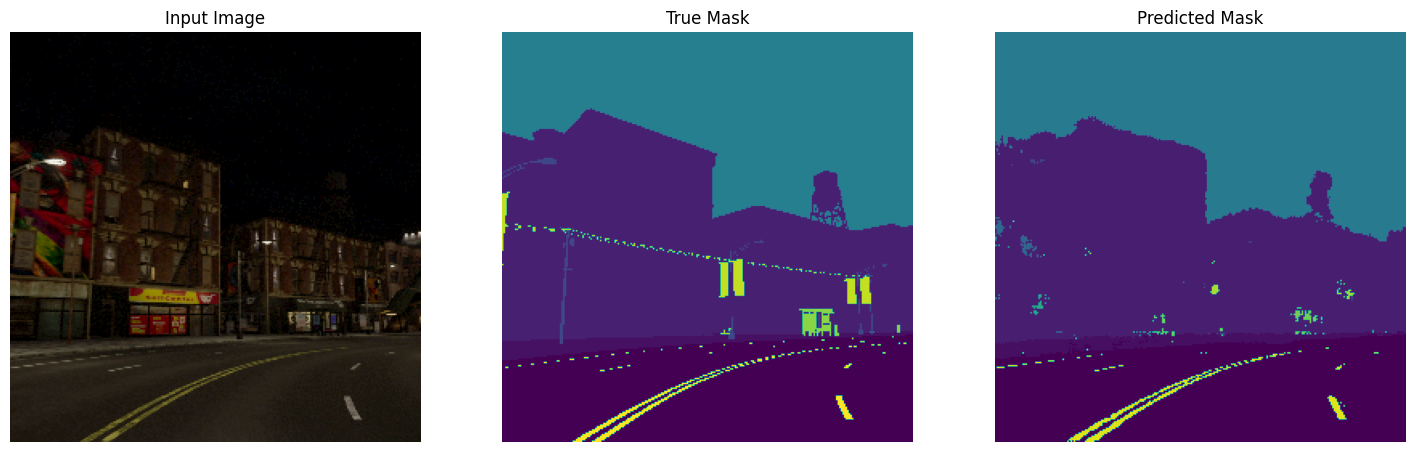

-------------------------------------------------------
------------------- Testing: PspNet -----------------------
-------------------------------------------------------
Training time: 111.65816187858582 seconds
Accuracy: 0.9566787842451407
Precision: 0.9555525705781802
F1 Score: 0.9549067425883908
Jaccard Index (IoU): 0.9229528797291087
[[5571840       0]
 [      0       0]]
1/1 [==============================] - 0s 18ms/step


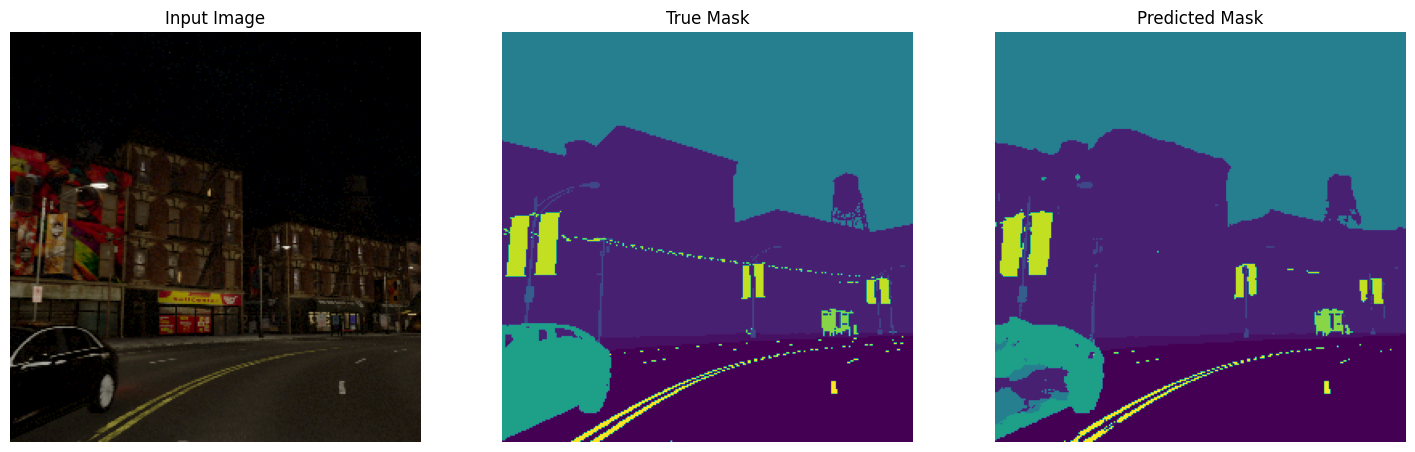

1/1 [==============================] - 0s 17ms/step


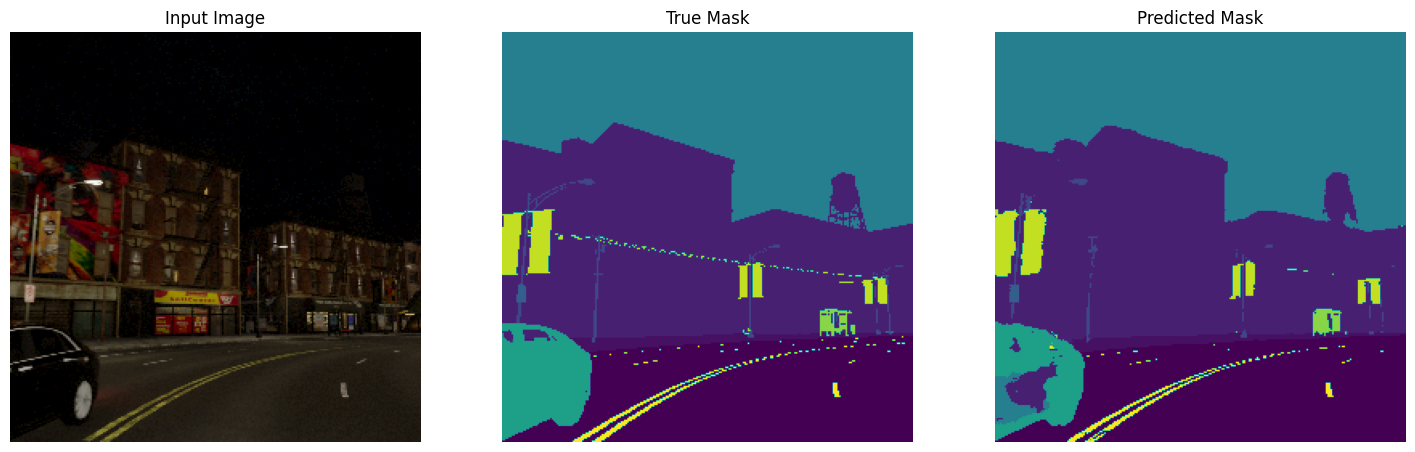

1/1 [==============================] - 0s 17ms/step


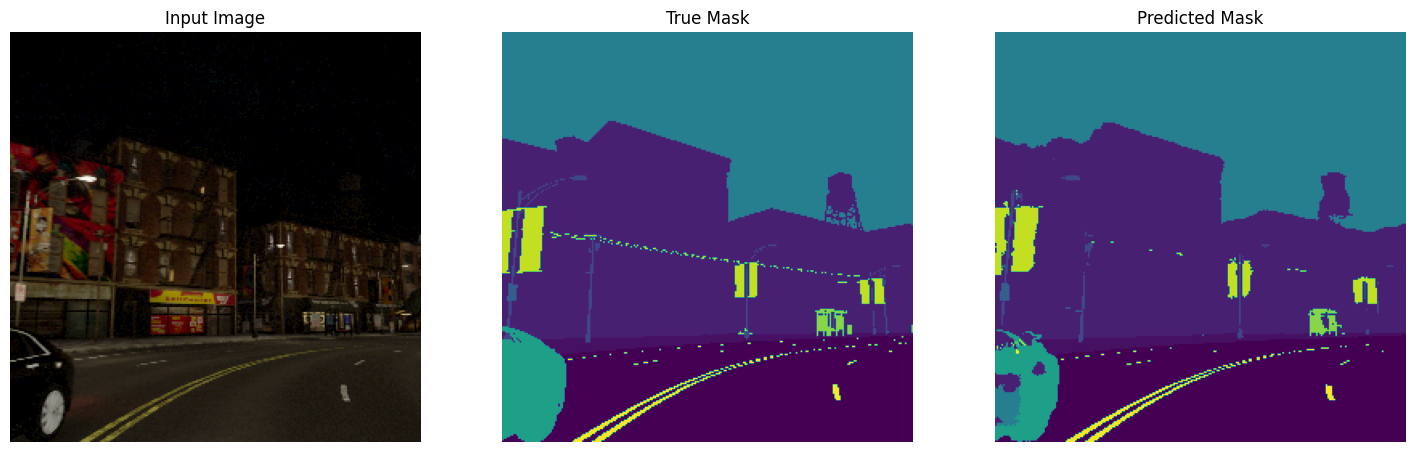

1/1 [==============================] - 0s 18ms/step


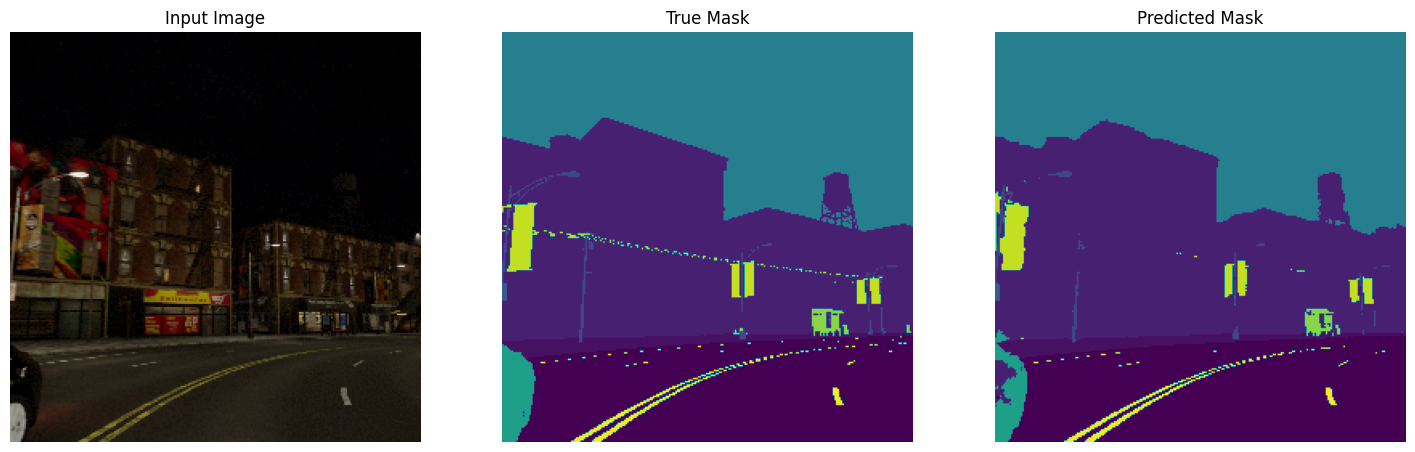

In [15]:

model_metrics = {}

#modelChoice = 'Unet'
for modelChoice in modelList:

    print("-------------------------------------------------------")
    print("------------------- Testing: "+modelChoice+" -----------------------")
    print("-------------------------------------------------------")
    
    if(modelChoice == 'Segnet'):
        batchSize = 10 #Lower batchSize to fit into GPU mem
        bufferSize = 500
    elif(modelChoice == 'PspNet'):
        batchSize = 5 #Lower batchSize to fit into GPU mem
        bufferSize = 500
    else:
        batchSize = 32
        bufferSize = 500

    #trainDataset = genDataset(X_train, y_train, bufferSize, batchSize)
    #valDataset = genDataset(X_val, y_val, bufferSize, batchSize)
    testDataset = genDataset(X_test, y_test, bufferSize, batchSize)

    #Model Load

    if(modelChoice == 'Segnet'):
        custom_objects = {
            'MaxPoolingWithArgmax2D': Models.Segnet.MaxPoolingWithArgmax2D,
            'MaxUnpooling2D':  Models.Segnet.MaxUnpooling2D
        }
        
        model = tf.keras.models.load_model('./Models/'+modelChoice + '.h5', custom_objects=custom_objects)
    else:

        model = tf.keras.models.load_model('./Models/'+modelChoice + '.h5')
    
    import time
    start_time = time.time() #Timer for training time 

    preds,masks = predictDatasetImages(testDataset, model)
    
    flat_preds = np.concatenate(preds).flatten()
    flat_masks = np.concatenate(masks).flatten()
    end_time = time.time() #test time calculation
    predictAllVideos(preds,masks,modelChoice)

    # Calculate evaluation metrics
    accuracy, precision, f1, jaccard = calculate_metrics(flat_masks, flat_preds)
    confusion_m = confusion_matrix(flat_masks, flat_preds,labels=[1, 0])

    testing_time = end_time - start_time
    print(f"Training time: {testing_time} seconds")
    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'F1 Score: {f1}')
    print(f'Jaccard Index (IoU): {jaccard}')
    print(confusion_m)

    model_metrics[modelChoice] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'F1 Score': f1,
        'Jaccard Index (IoU)': jaccard,
        'Confusion Matrix': confusion_m.tolist(),  # Convert to list for better readability
        'Confusion Matrix': testing_time   
    }

    show_predictions(model, testDataset,4)

In [16]:
import pandas as pd
# Create a DataFrame from the collected metrics dictionary
df = pd.DataFrame(model_metrics)

# Transpose the DataFrame for better readability
df = df.transpose()

# Display the DataFrame
print(df)

         Accuracy  Precision  F1 Score  Jaccard Index (IoU)  Confusion Matrix
Unet     0.961288   0.960473  0.960291             0.931778         56.727228
DeepLab  0.924987   0.915042  0.916499             0.869079         43.150084
Segnet   0.816485   0.820572  0.781815             0.703471         60.170923
PspNet   0.956679   0.955553  0.954907             0.922953        111.658162
